In [1]:
import os
import networkx as nx
import numpy as np
import random
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import pandas as pd
from main import load_edges
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors


### Summary for the whole dataset

In [2]:
file_sum = 'results\\network_summary.csv'
summ_file = pd.read_csv(file_sum)
df_sum = pd.DataFrame(summ_file)

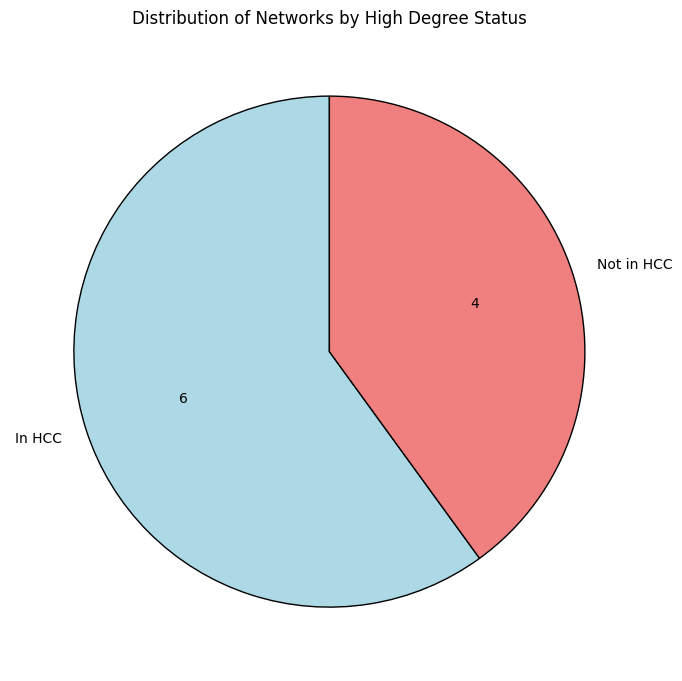

In [18]:
# Count occurrences of True and False
counts = df_sum['has_high_degree_not_in_hcc'].value_counts()

# Create a pie chart with custom labels and counts
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=["In HCC","Not in HCC"], autopct=lambda p: f'{p * sum(counts) / 100:.0f}', 
        colors=["lightblue", "lightcoral"], startangle=90, wedgeprops={"edgecolor": "black"})

# Add a title
plt.title("Distribution of Networks by High Degree Status")

# Show the plot
plt.tight_layout()
plt.show()

### !!! Define the Networks node ID here for the analisys !!! 

In [4]:
# change the node number from the following list to see the analysis for the network
# network_node_id = [0, 107, 1684, 1912, 3437, 348, 3980, 414, 686, 698]
Num = 0
# if you want to save the result plots change to True
save_png = False

In [5]:
network_row = summ_file[summ_file['network_id'] == Num]

if not network_row.empty:
    if network_row['has_high_degree_not_in_hcc'].iloc[0] == False:
        print("This network is a highly clustered network")
    else:
        print("This network is not a highly clustered network")
else:
    print("Network ID not found")


output_dir = f".//graphs//{Num}"  
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

This network is not a highly clustered network


### Load data

In [6]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [7]:
# Directories for data input and output
DATA_DIR = "data"  # Directory containing .edges files
RESULTS_DIR = "results"  # Directory to save CSV results
GRAPHS_DIR = "graphs"  # Directory to save generated graphs
LOGS_DIR = "logs"  # Directory to save log files

# Create output directories if they don't exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(GRAPHS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

In [8]:
filep = f'data/{Num}.edges'

edge_list = load_edges(filep)
# Step 1: Create an empty graph
G = nx.Graph()

# Step 2: Read edges from the file and add them to the graph
with open(filep, "r") as file:
    for line in file:
        # Split each line into two nodes (assuming whitespace-delimited edges)
        nodes = line.strip().split()
        if len(nodes) == 2:
            u, v = map(int, nodes)  # Convert nodes to integers
            G.add_edge(u, v)       # Add edge to the graph

# Step 3: Output basic graph information
# print(nx.info(G))  # Prints the number of nodes and edges

### Graph without degrees


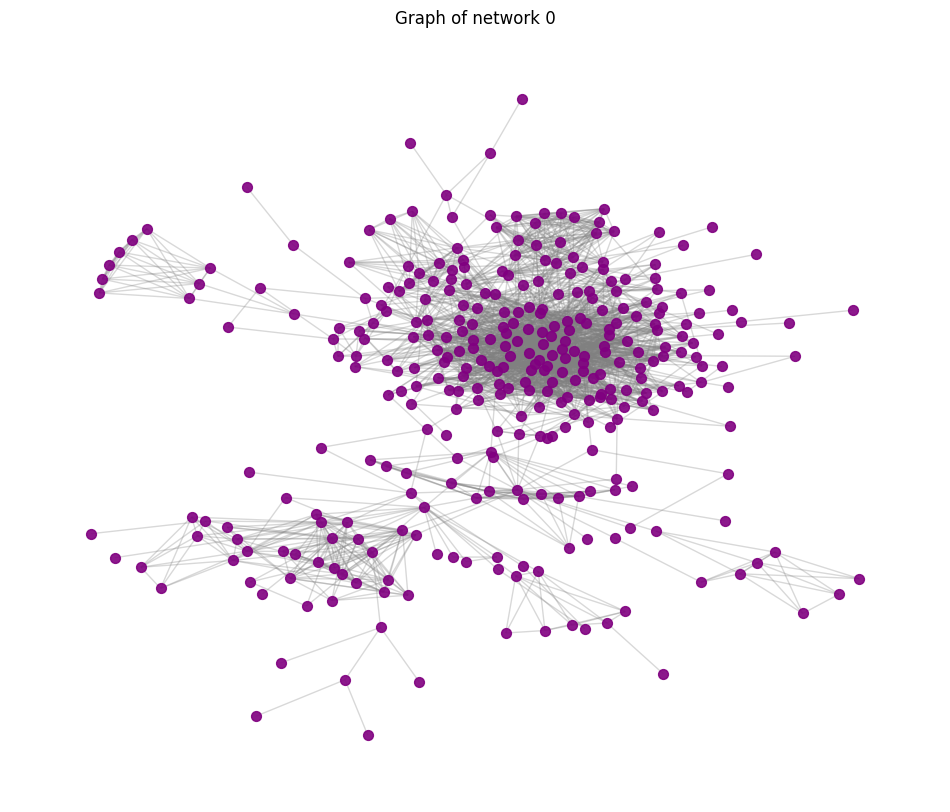

In [9]:
pos = nx.kamada_kawai_layout(G)
# Step 4: Draw the graph
fig, ax = plt.subplots(figsize=(12, 10))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")

# Draw nodes with colors based on their degree
nx.draw_networkx_nodes(
    G,
    pos,
    node_color= 'purple',
    node_size=50,
    alpha=0.9,

)
plt.title(f"Graph of network {Num}")
plt.axis("off")
if save_png == True:
    plt.savefig(f"{output_dir}/{Num}_network_graph.png", format="png")
plt.show()

### Graph colored degrees

In [10]:
# Load or create a graph

# Step 1: Calculate the degree of each node
degrees = dict(G.degree())  # Node degree dictionary
node_sizes = [v * 1.5 for v in degrees.values()]

# Step 2: Normalize degree values for the color scale
min_degree = min(degrees.values())
max_degree = max(degrees.values())


In [11]:
# Normalize the degree values between 0 and 1
norm = mcolors.Normalize(vmin=min_degree, vmax=max_degree)


In [12]:
cmap = cm.inferno  # Choose a colormap (e.g., 'viridis', 'coolwarm')

# Map the degree of each node to a color
node_colors = [cmap(norm(degrees[node])) for node in G.nodes()]

# Step 3: Create positions for nodes using spring layout
pos = nx.kamada_kawai_layout(G)

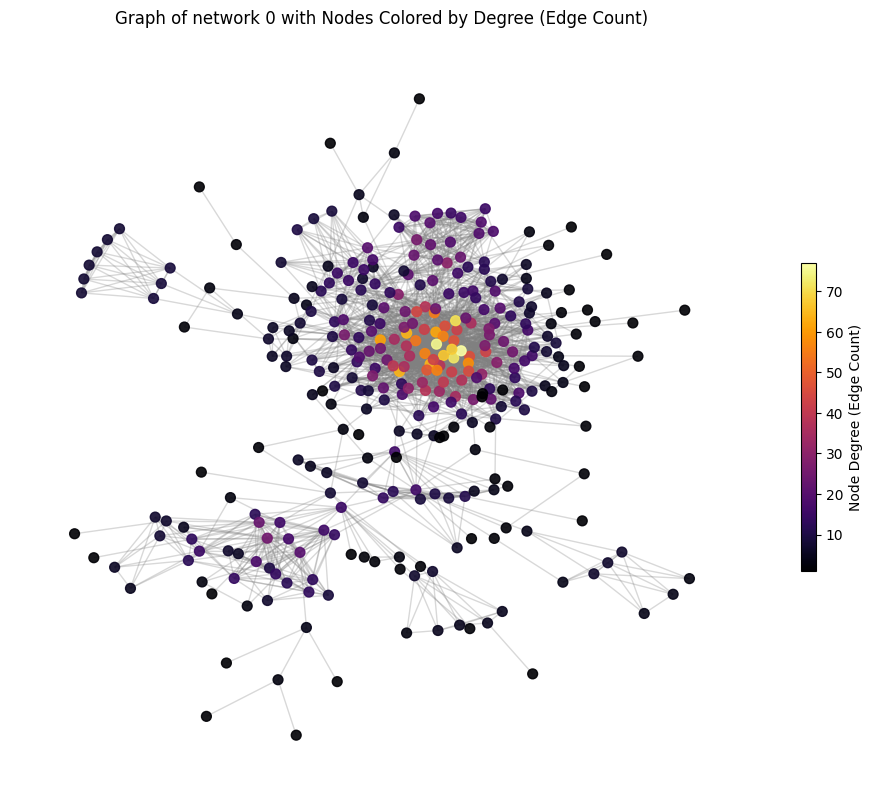

In [13]:
# Step 4: Draw the graph
fig, ax = plt.subplots(figsize=(12, 10))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")

# Draw nodes with colors based on their degree
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=50,
    alpha=0.9,

)

# # Optional: Draw labels
# nx.draw_networkx_labels(
#      G, pos,  ,font_size=5, font_color="black", ax=ax
#  )

# Step 5: Add a color bar


# Finalize and display
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the color bar
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", shrink=0.4)
cbar.set_label("Node Degree (Edge Count)")
plt.title(f"Graph of network {Num} with Nodes Colored by Degree (Edge Count)")
plt.axis("off")
if save_png == True:
    plt.savefig(f"{output_dir}/{Num}_network_graph_colored_degree.png", format="png")
plt.show()

### Graph with communities (node size according to node degree)

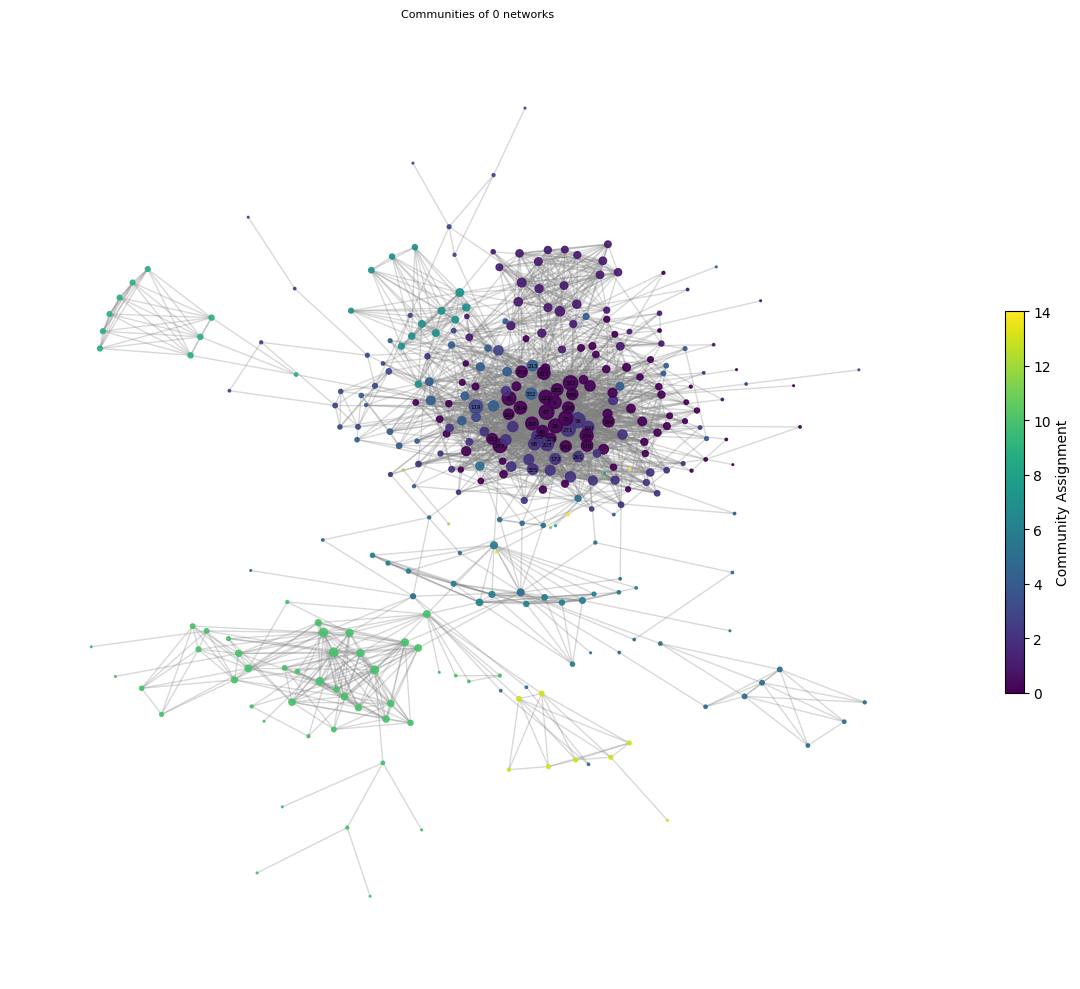

In [14]:
# Community detection for coloring nodes based on communities
partition = community_louvain.best_partition(G)
community_colors = [partition[node] for node in G.nodes()]

# ------------------- 3. Visualization ---------------------
fig, ax = plt.subplots(figsize=(12, 10))  # Explicitly create figure and axes

# Draw edges with transparency
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray", ax=ax)

# Draw nodes with community-based colors
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    cmap=cm.viridis,
    node_color=community_colors,
    alpha=0.9,
    ax=ax
)

# # Draw labels only for high-degree nodes (degree > threshold)
degree_threshold = np.percentile(list(degrees.values()), 90)

high_degree_nodes = {node: node for node, deg in degrees.items() if deg >= degree_threshold }
nx.draw_networkx_labels(
     G, pos, labels=high_degree_nodes, font_size=4, font_color="black", ax=ax
 )

# Add colorbar for community-based coloring
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(community_colors), vmax=max(community_colors)))
sm.set_array([])  # Necessary for creating colorbar
cb = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.4)
cb.set_label("Community Assignment")

# ------------------- 4. Enhancements ---------------------
ax.set_title(f"Communities of {Num} networks", fontsize=8)
plt.axis("off")  # Hide axis for better visualization
if save_png == True:
 plt.savefig(f"{output_dir}/{Num}_communities_graph.png", format="png")
plt.tight_layout()


### Node properties and top nodes

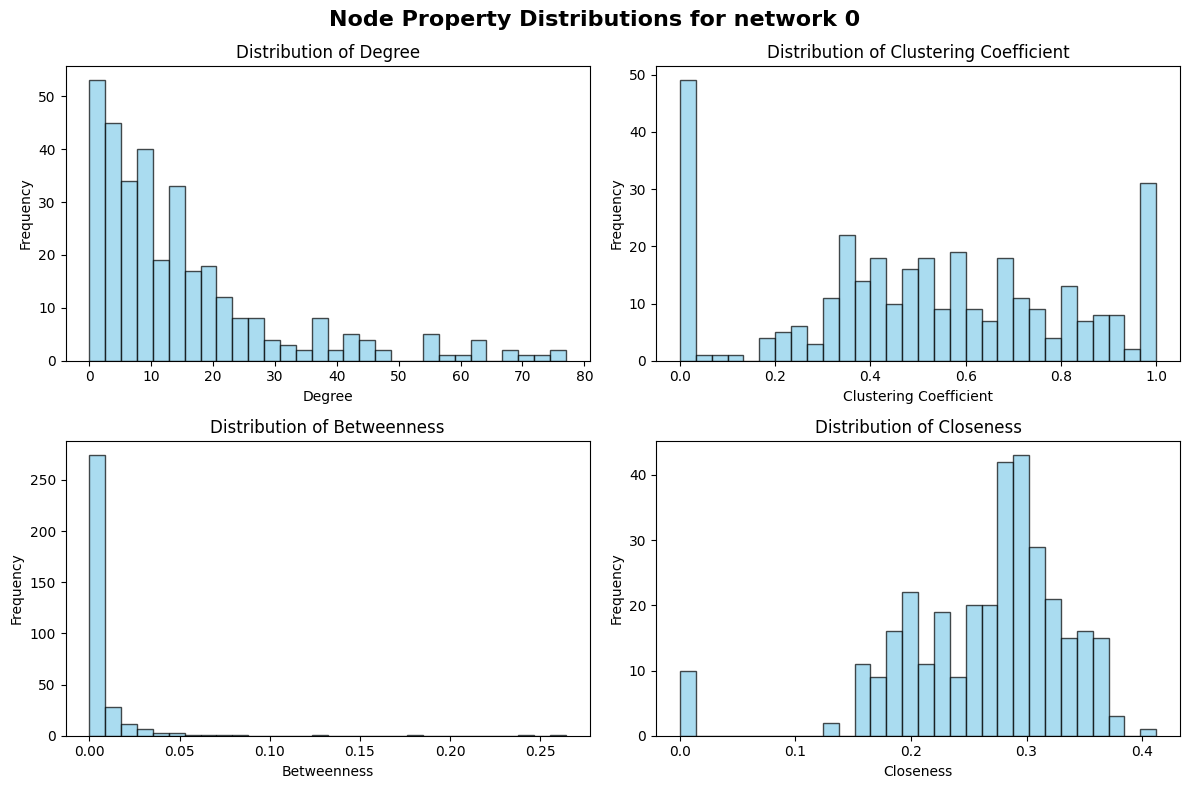

In [15]:
filenamecsv = f'./results/{Num}_node_properties.csv'
# Load the CSV
df_spread = pd.read_csv(filenamecsv)

# Plot histograms for each metric
metrics = ["Degree", "Clustering Coefficient", "Betweenness", "Closeness"]
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    plt.hist(df_spread[metric], bins=30, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(f"Distribution of {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")

plt.suptitle(f"Node Property Distributions for network {Num}", fontsize=16, fontweight="bold")

plt.tight_layout()
if save_png == True:
    plt.savefig(f"{output_dir}/{Num}_node_properties.png", format="png")
plt.show()


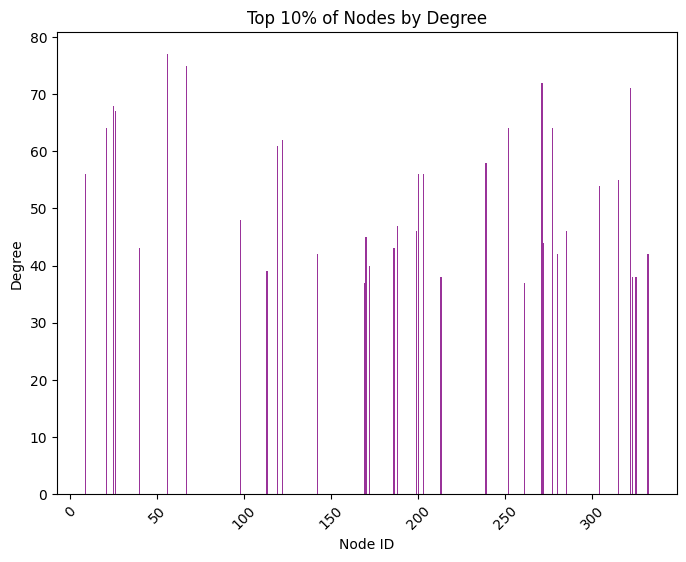

In [16]:
## Calculate the threshold for the top 10% of nodes by Degree
top_10_percent_threshold = np.percentile(df_spread["Degree"], 90)

# Filter nodes with Degree greater than or equal to the threshold
top_nodes = df_spread[df_spread["Degree"] >= top_10_percent_threshold]

# # Highlight top nodes by Degree
# top_nodes = df.nlargest(10, "Degree")

plt.figure(figsize=(8, 6))
plt.bar(top_nodes["Node"], top_nodes["Degree"], color="purple", alpha=0.8)
plt.title("Top 10% of Nodes by Degree")
plt.xlabel("Node ID")
plt.ylabel("Degree")
plt.xticks(rotation=45)
if save_png == True:
    plt.savefig(f"{output_dir}/{Num}_top_10perc.png", format="png")
plt.show()


### Statistical analysis plots - for all the networks

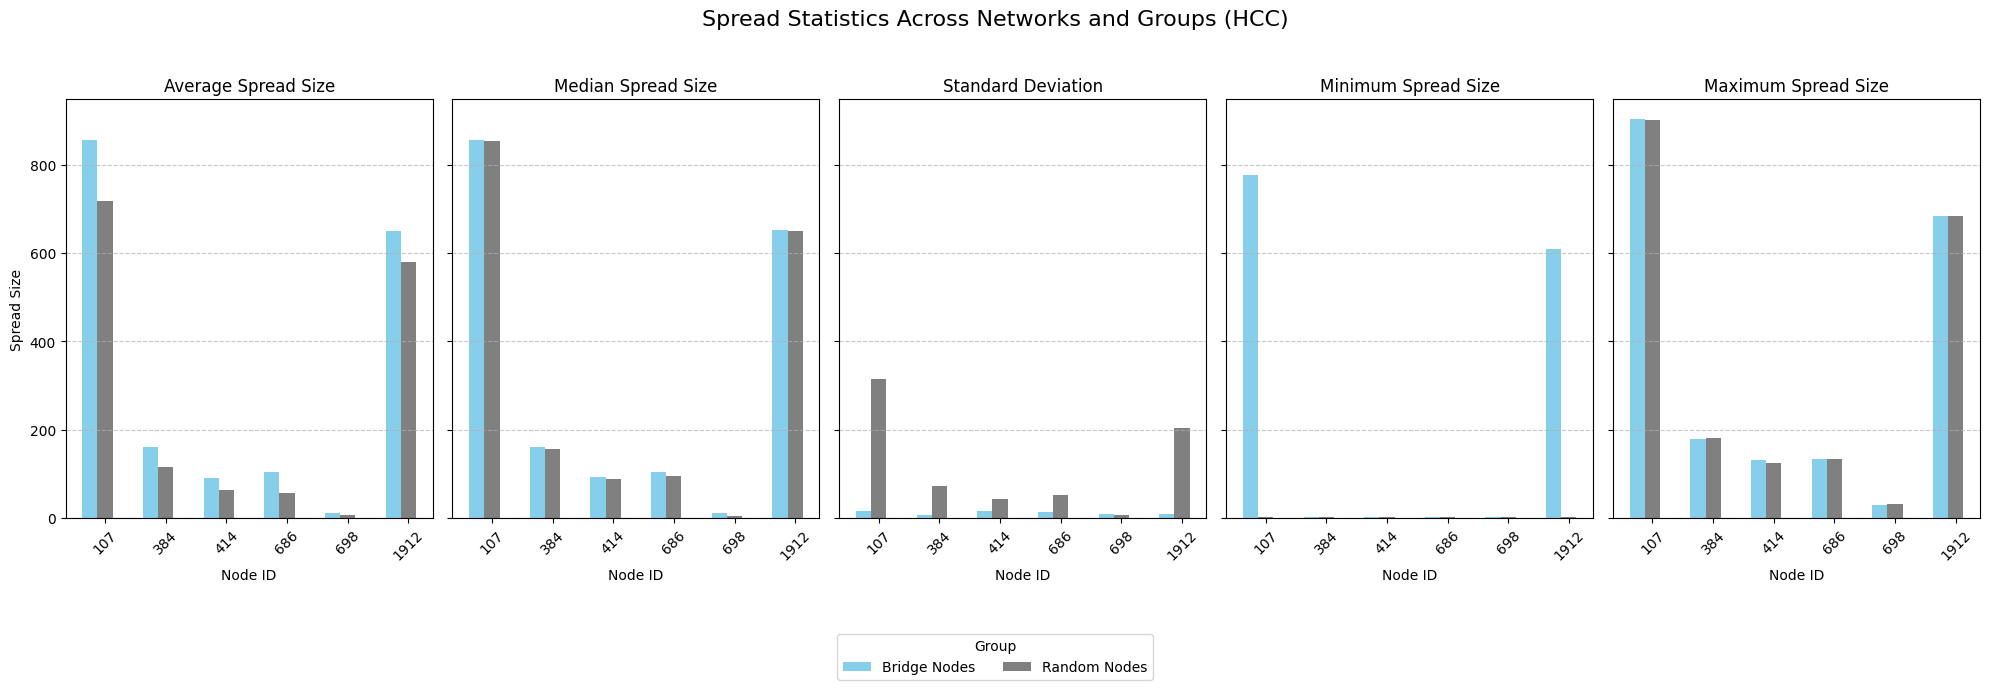

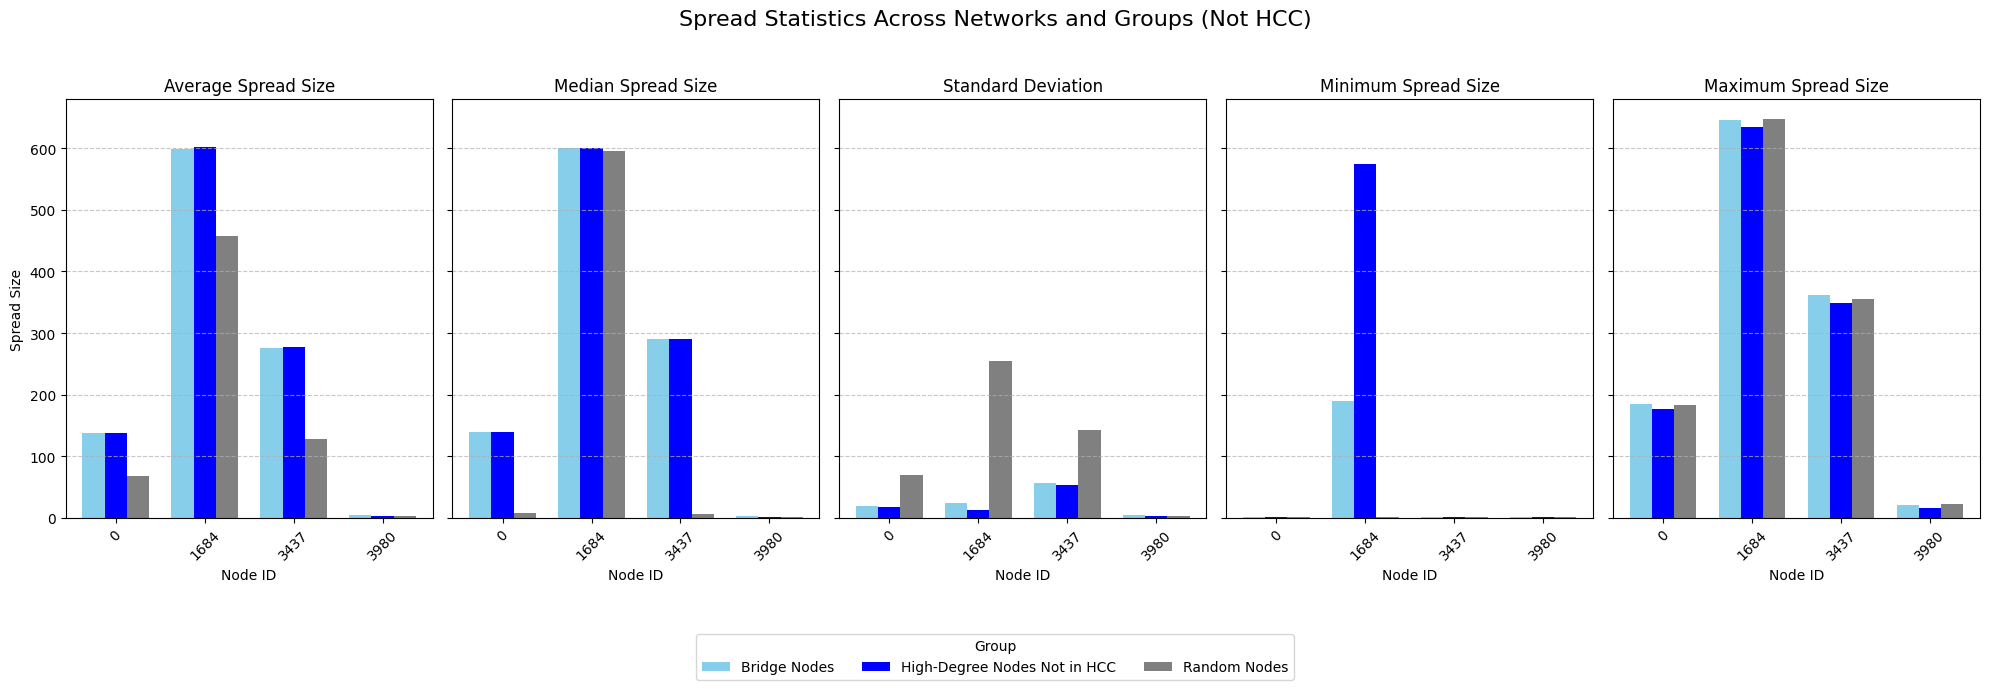

In [17]:
### Spread statistic plots
# Load the dataset from the CSV file
file_path = "results/spread_statistics_overview_all_nodes.csv"
df = pd.read_csv(file_path)

# Filter out "High-Degree Nodes Not in HCC" when HCC is True
filtered_df = df[~((df["HCC"] == "HCC") & (df["Group"] == "High-Degree Nodes Not in HCC"))]

# Group colors
group_colors = {
    "Bridge Nodes": "Skyblue",
    "High-Degree Nodes Not in HCC": "Blue",
    "Random Nodes": "grey"
}

# Metrics to plot
metrics = ["Average Spread Size", "Median Spread Size", "Standard Deviation", "Minimum Spread Size", "Maximum Spread Size"]

# Group by HCC and create separate plots for HCC and Not HCC
grouped_by_hcc = filtered_df.groupby("HCC")

for hcc_status, group_data in grouped_by_hcc:
    # Create subplots for each metric
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6), sharey=True)
    fig.suptitle(f"Spread Statistics Across Networks and Groups ({hcc_status})", fontsize=16)

    for ax, metric in zip(axes, metrics):
        # Pivot the data for plotting
        pivot_df = group_data.pivot_table(index="Node ID", columns="Group", values=metric)

        # Generate bar positions for grouped bars
        x = np.arange(len(pivot_df.index))  # x-axis positions for each network (Node ID)
        bar_width = 0.25  # Width of each bar
        offsets = np.arange(len(pivot_df.columns)) * bar_width  # Offset for each group

        # Plot each group with specific colors
        for i, column in enumerate(pivot_df.columns):
            ax.bar(x + offsets[i], pivot_df[column], width=bar_width, label=column, color=group_colors[column])

        # Customize the plot
        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(pivot_df.index, rotation=45)
        ax.set_title(metric)
        ax.set_xlabel("Node ID")
        ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Add legend only once, outside all subplots
    axes[0].set_ylabel("Spread Size")
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Group", loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(pivot_df.columns))

    plt.tight_layout(rect=[0, 0, 1, 0.95])#
    # plt.savefig(os.path.join(GRAPHS_DIR, "Spread_metrics.png"))
    plt.show()
